# Import

In [1]:
import os
import sys
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../../')

In [3]:
from fiducial_detect.data import *
from fiducial_detect.models import *

# Utility

In [4]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [5]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [6]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [7]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [8]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

In [9]:
class MetricErrorRate():
    def __call__(self, y_hat, y):
        return 1 - MetricAccuracy()(y_hat, y)

# Train

In [10]:
# Config
batch_size = 28
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 500
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['err'] = MetricErrorRate()

# Checkpoint metric
metric_checkpoint = 'err'

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.33),
                    RandomBrightness((-0.5, 0.5), 0, 0.33),
                    RandomBlur((0, 1.5), 0.50, 0.50),
                    Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                    Random(RandomGrad((-0.5, 0.5))     , 0.9),
                    Clip((-1,1)),
                    ToTensor()])

dl_trn = IsliceDataloader(num_batches,
                          SyntheticMaskDataSet(tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory, 
                          worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [12]:
tfms_val = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    ToTensor()])

dl_val = DataLoader(RealMaskDataSet(Path('../../data/ground_truth'), tfms=tfms_val), 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory, 
                    worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

<IPython.core.display.Javascript object>


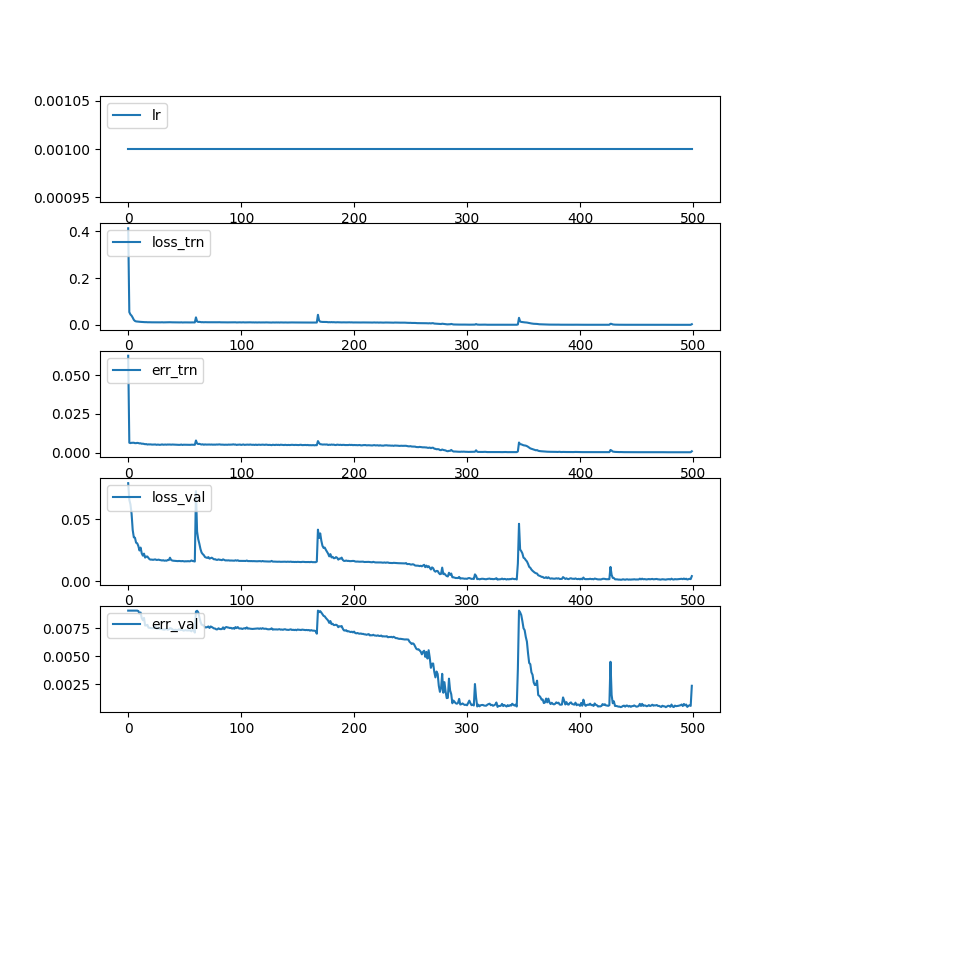

            lr   loss_trn    err_trn   loss_val    err_val
0      0.00100    0.41262    0.06271    0.07940    0.00909 - err decreased; checkpointing...
1      0.00100    0.05476    0.00638    0.06595    0.00909
2      0.00100    0.04467    0.00614    0.06222    0.00909
3      0.00100    0.03962    0.00632    0.05477    0.00909
4      0.00100    0.03130    0.00632    0.04153    0.00909
5      0.00100    0.02180    0.00637    0.03555    0.00909
6      0.00100    0.01703    0.00611    0.03523    0.00909
7      0.00100    0.01511    0.00612    0.03120    0.00909
8      0.00100    0.01450    0.00628    0.03073    0.00909
9      0.00100    0.01391    0.00617    0.02854    0.00905 - err decreased; checkpointing...
10     0.00100    0.01318    0.00594    0.02490    0.00881 - err decreased; checkpointing...
11     0.00100    0.01312    0.00601    0.02727    0.00892
12     0.00100    0.01280    0.00571    0.02262    0.00842 - err decreased; checkpointing...
13     0.00100    0.01271    0.00578  

125    0.00100    0.01071    0.00500    0.01599    0.00742
126    0.00100    0.01052    0.00495    0.01598    0.00743
127    0.00100    0.01028    0.00480    0.01648    0.00750
128    0.00100    0.01079    0.00506    0.01593    0.00738
129    0.00100    0.01059    0.00497    0.01594    0.00741
130    0.00100    0.01044    0.00488    0.01589    0.00740
131    0.00100    0.01082    0.00509    0.01584    0.00741
132    0.00100    0.01051    0.00494    0.01580    0.00739
133    0.00100    0.01078    0.00504    0.01585    0.00741
134    0.00100    0.01036    0.00486    0.01585    0.00742
135    0.00100    0.01083    0.00510    0.01573    0.00738
136    0.00100    0.01063    0.00503    0.01573    0.00740
137    0.00100    0.01048    0.00494    0.01571    0.00737
138    0.00100    0.01043    0.00487    0.01582    0.00741
139    0.00100    0.01071    0.00504    0.01583    0.00742
140    0.00100    0.01044    0.00490    0.01571    0.00738
141    0.00100    0.01037    0.00488    0.01583    0.007

251    0.00100    0.00851    0.00392    0.01354    0.00610 - err decreased; checkpointing...
252    0.00100    0.00854    0.00390    0.01378    0.00616
253    0.00100    0.00856    0.00387    0.01343    0.00608 - err decreased; checkpointing...
254    0.00100    0.00851    0.00385    0.01276    0.00588 - err decreased; checkpointing...
255    0.00100    0.00799    0.00361    0.01264    0.00568 - err decreased; checkpointing...
256    0.00100    0.00775    0.00352    0.01264    0.00561 - err decreased; checkpointing...
257    0.00100    0.00771    0.00351    0.01255    0.00563
258    0.00100    0.00807    0.00369    0.01226    0.00553 - err decreased; checkpointing...
259    0.00100    0.00785    0.00355    0.01254    0.00541 - err decreased; checkpointing...
260    0.00100    0.00762    0.00348    0.01210    0.00517 - err decreased; checkpointing...
261    0.00100    0.00745    0.00338    0.01277    0.00540
262    0.00100    0.00751    0.00343    0.01333    0.00549
263    0.00100    0.

376    0.00100    0.00143    0.00051    0.00214    0.00073
377    0.00100    0.00136    0.00049    0.00206    0.00069
378    0.00100    0.00136    0.00048    0.00210    0.00074
379    0.00100    0.00126    0.00045    0.00240    0.00087
380    0.00100    0.00107    0.00040    0.00212    0.00080
381    0.00100    0.00130    0.00044    0.00242    0.00084
382    0.00100    0.00139    0.00051    0.00184    0.00068
383    0.00100    0.00102    0.00038    0.00185    0.00066
384    0.00100    0.00097    0.00036    0.00193    0.00068
385    0.00100    0.00114    0.00042    0.00338    0.00131
386    0.00100    0.00105    0.00039    0.00263    0.00102
387    0.00100    0.00102    0.00037    0.00188    0.00068
388    0.00100    0.00099    0.00037    0.00239    0.00089
389    0.00100    0.00101    0.00038    0.00186    0.00069
390    0.00100    0.00087    0.00033    0.00175    0.00067
391    0.00100    0.00089    0.00034    0.00222    0.00081
392    0.00100    0.00095    0.00036    0.00244    0.000

In [13]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
m_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3), end='')
    
    # Checkpoint
    if m_val[metric_checkpoint] < m_checkpoint:
        print(f' - {metric_checkpoint} decreased; checkpointing...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        m_checkpoint = m_val[metric_checkpoint]
        
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
# Checkpoint last
print(f' - checkpointing last...')
save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/last.pth'))
    
%matplotlib inline

# Test

In [34]:
model, optimizer, _ = load_checkpoint(model, optimizer, 'checkpoints/best.pth')

Inspect training dataset

In [35]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [36]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [37]:
idx = 0

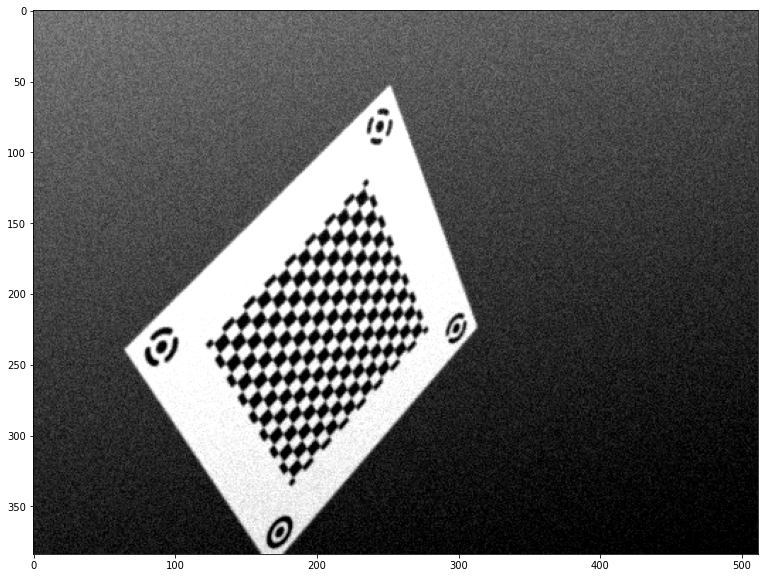

In [38]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

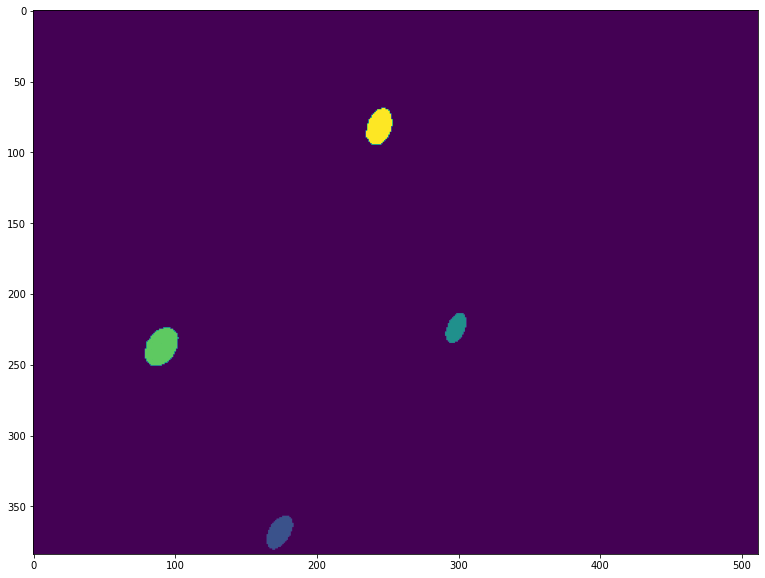

In [39]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

Inspect validation dataset

In [40]:
X, y = next(iter(dl_val))
X, y = X.to(device), y.to(device)

In [65]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [66]:
idx = 0

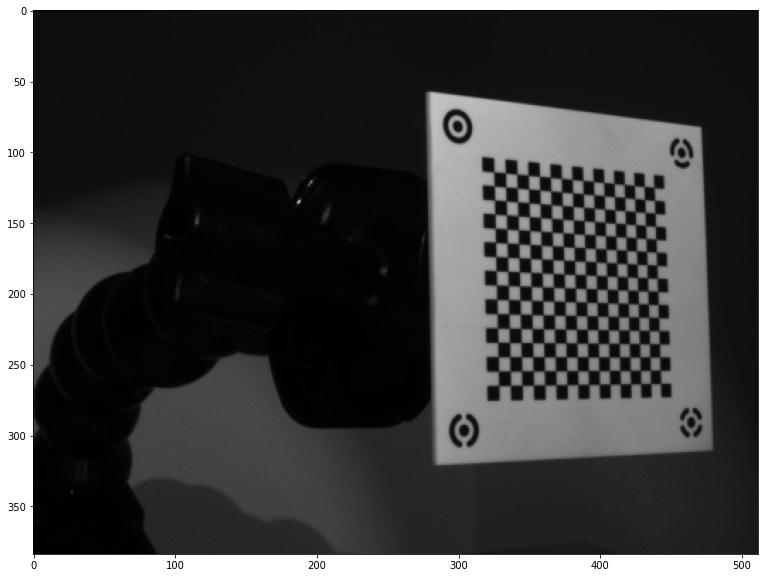

In [67]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

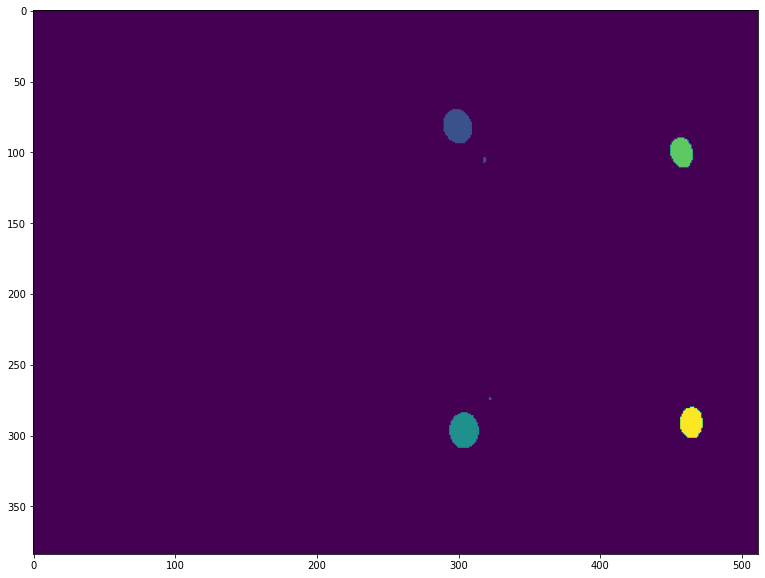

In [68]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

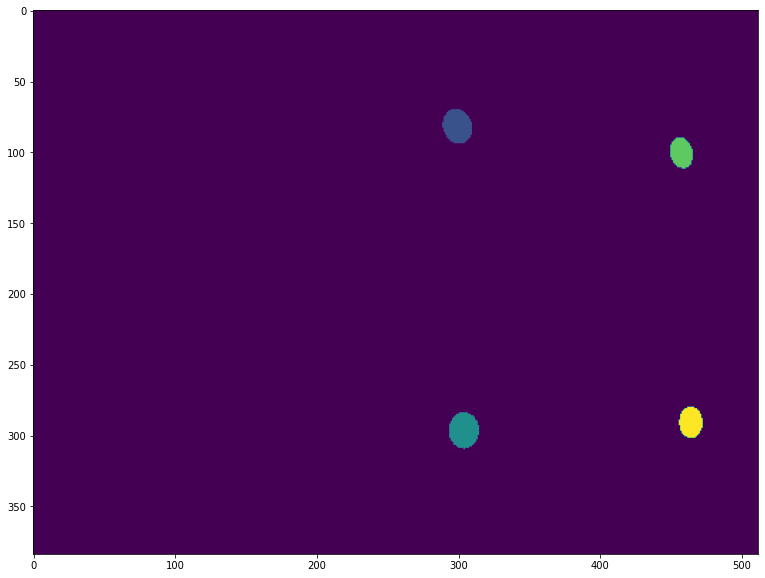

In [69]:
plt.figure(figsize=(15,10))
plt.imshow(y.cpu().detach()[idx], vmin=0, vmax=4)

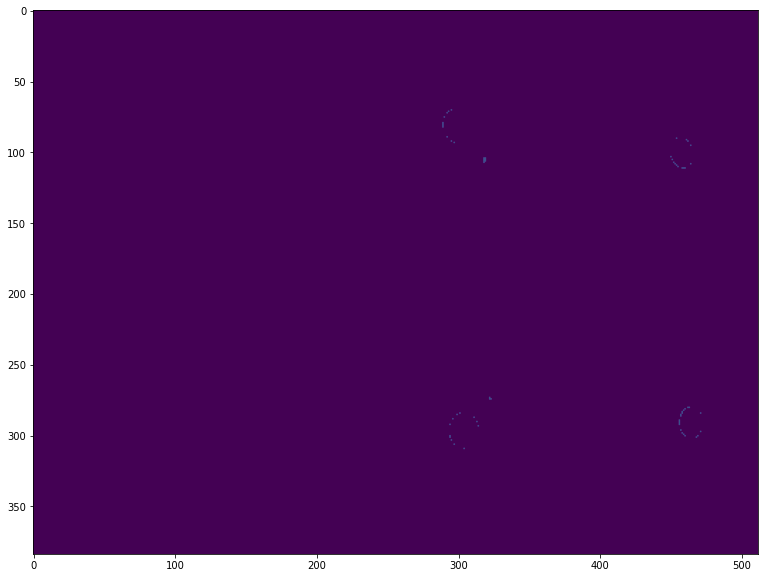

In [70]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx] != y.cpu().detach()[idx], vmin=0, vmax=4)